Note, still in the process of experimenting with parameters

Import packages

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import datetime as dt

In [69]:
data = pds.read_pickle('added_t.pkl')

In [7]:
data.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number,label,t
0,1,1,2018-02-16 04:48:40+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1,72,71.0
1,3,3,2018-02-16 04:48:41+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1,72,70.0
2,4,4,2018-02-16 04:48:42+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1,72,69.0
3,5,5,2018-02-16 04:48:43+01:00,ObservedPositionEvent,5432,0,58.414257,15.571004,147.300003,0.0,NaN,1,1,72,68.0
4,6,6,2018-02-16 04:48:44+01:00,ObservedPositionEvent,5432,0,58.414257,15.571006,147.300003,0.0,NaN,1,1,72,67.0


Import data

In [9]:
df = pds.read_csv('../../bus203_all_labelled.csv')

# Ignore all other stuff than the ObservedPositionEvent
df = df[df['event'] == "ObservedPositionEvent"]

In [10]:
df.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number,time_since_journey_start,label
1,1,1,2018-02-16 04:48:40+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1,0,72
3,3,3,2018-02-16 04:48:41+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1,0,72
4,4,4,2018-02-16 04:48:42+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1,0,72
5,5,5,2018-02-16 04:48:43+01:00,ObservedPositionEvent,5432,0,58.414257,15.571004,147.300003,0.0,NaN,1,1,0,72
6,6,6,2018-02-16 04:48:44+01:00,ObservedPositionEvent,5432,0,58.414257,15.571006,147.300003,0.0,NaN,1,1,0,72


One hot encode segments, normalize columns and create final dataset

In [70]:
df = data

In [71]:
# Make segments categorical
dataset = pds.get_dummies(df['segment_number'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 
dataset['hr_sin'] = np.sin(df.timestamp.dt.hour*(2.*np.pi/24))
dataset['hr_cos'] = np.cos(df.timestamp.dt.hour*(2.*np.pi/24))

# Convert to radians befor trigonometric functions
dataset['dir_sin'] = np.sin(df.direction*(np.pi/180))
dataset['dir_cos'] = np.cos(df.direction*(np.pi/180))

dataset['speed'] = (df['speed']-df['speed'].min())/(df['speed'].max()-df['speed'].min())
#dataset['time_since_journey_start'] = (df['time_since_journey_start']-df['time_since_journey_start'].min())/(df['time_since_journey_start'].max()-df['time_since_journey_start'].min())

dataset['latitude'] = (df['latitude']-df['latitude'].min())/(df['latitude'].max()-df['latitude'].min())
dataset['longitude'] = (df['longitude']-df['longitude'].min())/(df['longitude'].max()-df['longitude'].min())

# Include journey number to select entire journeys
dataset['journey_number'] = df['journey_number']

Select an arbitrary number of test journeys

In [72]:
num_test_segments = 100 
msk = np.random.randint(1, dataset.journey_number.unique()[-1], num_test_segments)
mask = dataset['journey_number'].isin(msk)

Divide training and test data, 80% training data

In [73]:
train_input = dataset[~mask]
test_input = dataset[mask]

train_labels = df['t'][~mask]
test_labels = df['t'][mask]

In [74]:
# Journey numbers were needed up until this point
train_data = train_input.drop(columns=['journey_number'])
test_data = test_input.drop(columns=['journey_number'])

Build model

In [75]:
model = keras.Sequential([
	keras.layers.Dense(len(train_data.columns), activation=tf.nn.sigmoid, input_shape=(train_data.shape[1],)),
    keras.layers.Dense(len(train_data.columns)),
    keras.layers.Dense(len(train_data.columns)),
    keras.layers.Dense(len(train_data.columns)),
    keras.layers.Dense(3),
	keras.layers.Dense(1)
	])

#optimizer = tf.train.RMSPropOptimizer(0.001)
optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_21 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_22 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_23 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 57        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 4         
Total params: 1,429
Trainable params: 1,429
Non-trainable params: 0
_________________________________________________________________
None


Fit model

In [76]:
EPOCHS=5
# Initial_epoch can be set to resume training after preciously run epochs
model.fit(train_data.values, train_labels.values, epochs = EPOCHS, validation_split=0.1, initial_epoch=0)

Train on 2900630 samples, validate on 322293 samples
Epoch 1/5
2900630/2900630 [==============================] - 180s 62us/step - loss: 13.4424 - mean_absolute_error: 13.4424 - val_loss: 12.7131 - val_mean_absolute_error: 12.7131
Epoch 2/5
2900630/2900630 [==============================] - 180s 62us/step - loss: 12.0930 - mean_absolute_error: 12.0930 - val_loss: 11.9775 - val_mean_absolute_error: 11.9775
Epoch 3/5
2900630/2900630 [==============================] - 161s 56us/step - loss: 11.8691 - mean_absolute_error: 11.8691 - val_loss: 11.8966 - val_mean_absolute_error: 11.8966
Epoch 4/5
2900630/2900630 [==============================] - 161s 55us/step - loss: 11.7619 - mean_absolute_error: 11.7619 - val_loss: 12.0856 - val_mean_absolute_error: 12.0856
Epoch 5/5
2900630/2900630 [==============================] - 166s 57us/step - loss: 11.6964 - mean_absolute_error: 11.6964 - val_loss: 11.9777 - val_mean_absolute_error: 11.9777


Evaluate model

In [77]:
model.evaluate(test_data.values, test_labels.values)

89077/89077 [==============================] - 2s 18us/step


[11.278602218223638, 11.278602218223638]

Roughly the same as the second "base" model.

An arbitrary number from `msk` is chosen, i.e. a journey, to a comparison with original data.

In [78]:
selected_journey = np.random.choice(msk)
to_test = test_input[test_input['journey_number'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey_number'])
predictions = model.predict(model_to_predict.values, batch_size=1, verbose=1)

830/830 [==============================] - 0s 585us/step


In [79]:
journey_ = test_input.index[test_input['journey_number'] == selected_journey]
j_labels = test_labels.loc[journey_]
j_labels = j_labels.reset_index().drop(columns=['index'])

Green line is the predicted time, red is the actual time. Note that the predicted time is the time it takes to drive an entire segment.


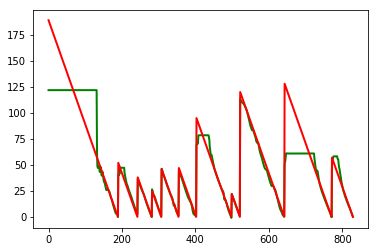

In [80]:
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(j_labels, color='red', linewidth=2, markersize=12)
plt.show()

Note that the plot above contains all 11 segments. The prediction is behaving a little bit different now as it seem to give different predictions for different places within each segment.

Below is a final scatterplot from the entire test data set.

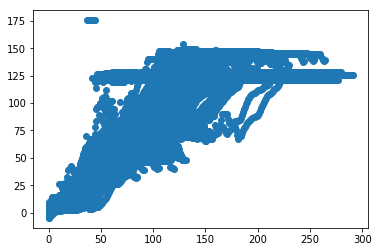

In [81]:
test_predictions = model.predict(test_data.values)
plt.scatter(test_labels.values, test_predictions)
plt.show()